# Assignment 2

## Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialdata2022/wiki/Assignment-1-and-2) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Monday, March the 28th, 2022 at 23:59. Hand in your files via [http://peergrade.io](http://peergrade.io/).

**Peergrading date and time**: _Remember that after handing in you have 1 week to evaluate a few assignments written by other members of the class_. Thus, the peer evaluations are due on Monday, April the 4th, 2022 at 23:59.

**Contributions**: In class I told you we will use DTU Learn. But Sune came up with a nicer idea!! **I'll send you a secret id by email later today** so you can add the contributions directly at the end of the notebook. They should look somewhat like this:

* id1: did this, this, and this
* id2: did that, that, and that
* id3: ...

**N.B.** It is NOT OK to say that each member contributed equally!

This Assignment is based on the last three weeks of the course (Week 6-8). Before going on please load the data with the following line. In this way, you won't need to submit anything else than the .ipynb file and we will be able to run your notebook!

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import DistanceMetric 
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from imblearn.under_sampling import RandomUnderSampler

In [87]:
# import data
column_list = ["age", "sex", "race", "juv_fel_count", "juv_misd_count", "juv_other_count",
               "priors_count", "two_year_recid", "days_b_screening_arrest"]

recidivism = pd.read_csv("https://raw.githubusercontent.com/suneman/socialdata2022/main/files/recidivism_dataset_sub.csv", usecols=column_list)

# clear RAM
del column_list

## Part 1: Predicting criminal recidivism: Build a Decision Tree or a Random Forest Model

The following exercises are a subset of the ones we did during Week 6. If you have doubts or need more help, go back to the Week 6 notebook. There, you will find additional hints to complete the assignment.

**Exercise 1.1:** Preprocess the data by only keeping records that have between $-30$ and $30$ days between the arrest and screening, then drop the `days_b_screening_arrest` column for the upcoming analysis.

In [88]:
# Exercise 1.1

# only keep records that have between -30 and 30 days between the arrest and screening

recidivism = recidivism.drop(recidivism[(recidivism.days_b_screening_arrest <= -30) | (recidivism.days_b_screening_arrest >= 30) | \
    (recidivism.days_b_screening_arrest.isna())].index)
    
# drop days_b_screening_arrest` for the upcoming analysis

recidivism = recidivism.drop(columns = ['days_b_screening_arrest'])

In [75]:
recidivism

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid
0,Male,69,Other,0,0,0,0,0
1,Male,34,African-American,0,0,0,0,1
2,Male,24,African-American,0,0,1,4,1
5,Male,44,Other,0,0,0,0,0
6,Male,41,Caucasian,0,0,0,14,1
...,...,...,...,...,...,...,...,...
7209,Male,23,African-American,0,0,0,0,0
7210,Male,23,African-American,0,0,0,0,0
7211,Male,57,Other,0,0,0,0,0
7212,Female,33,African-American,0,0,0,3,0


**Exercise 1.2:** Some features we are working with are categorical, so we need to deal with them by using encoders. There are many different types, but we will focus on the `OneHotEncoder` and the `LabelEncoder`: 
<br> Which encoder did you choose? Describe what it does and why you chose it.

In [89]:
# Exercise 1.2: Feature Engineering -> one hot encoding applied on the race column and label encoding on the sex column

# Get one hot encoding of column race
one_hot = pd.get_dummies(recidivism['race'], prefix = 'race')
# Drop column race as it is now encoded
recidivism = recidivism.drop('race',axis = 1)
# Join the encoded df
recidivism = recidivism.join(one_hot)

# label encoding on the sex column (0 -> Female; 1 -> Male)
recidivism['sex'] = recidivism['sex'].astype('category')
recidivism['sex'] = recidivism['sex'].cat.codes

# clear RAM
del one_hot

**Exercise 1.2:** 
<br>
<br> **a) Describe what these encoders (`OneHotEncoder` and `LabelEncoder`) do.**
<br> Label-encoding assigns an ascending numerical value to the unique categorical values of a column. The problem is that the model might misunderstand the encoded values by, for example, interpreting an order like 0 < 1 < 2 (ordinal characteristics) or distances between the values, for example, 3 is closer to 1 than 5 (interval characteristics).  One-hot-encoding overcomes this problem by assigning a column to all unique categorical values of a column. If the sample (row) belongs to a certain categorical value, the value is one in that particular column and zero in all others, so we have neither an order nor different intervals.
<br> **b) What variables need to be transformed? Which encoder did you choose? Why?**
<br> The column sex must be encode so that the model can interpret it. The column has two unique values (male and female), so if we apply one-hot coding, we create a column that contains no additional information, as the male column would consist of zeros and ones for two genders as well as the female, so we decided to apply label coding to generate only one column.
<br> The second categorical column is the race column. Here we applied one-hot-encoding to prevent the model from interpreting any ordinal or interval characteristics.

**Exercise 1.3:** Split the data in Train/Test sets by using a 70/30 split and `random_state=42`.

In [6]:
# Exercise 1.3

X = recidivism.loc[:, ~recidivism.columns.isin(['two_year_recid'])]
#0 = defendant did not recommit a crime within two years; 1 = the defendant recommitted a crime within two years
y = recidivism['two_year_recid']

# split the data set in train and test set (70/30 split) -> balanced data set grab equal amount of each target value
rus = RandomUnderSampler(random_state=42, sampling_strategy=1)
X_res, y_res = rus.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, stratify=y_res, random_state=42) 

# to check if equal amount of each target value
print(f'Balanced data set check for traning data: {np.unique(y_train, return_counts=True)}')
print(f'Balanced data set check for testing data: {np.unique(y_test, return_counts=True)}')

# clear RAM
del X, y, X_res, y_res

Balanced data set check for traning data: (array([0, 1], dtype=int64), array([1962, 1962], dtype=int64))
Balanced data set check for testing data: (array([0, 1], dtype=int64), array([841, 841], dtype=int64))


**Exercise 1.3:** Explanation of additional preprocessing
<br> In the exercise, we were not explicitly asked to balance the dataset, but we will later perform a classification task, so this preprocessing step is helpful to improve the model, e.g., by reducing bias. Balancing ensures that the number of samples is the same for each target value. The predictions of a model based on an unbalanced data set have problems with accurately predicting majority and minority classes because the model tends to develop a bias toward the majority class. When these models are evaluated on accuracy alone, the model appears to perform well, correctly predicting many samples of the majority class but failing on the minority class [1]. We choose the method of undersampling to balance the data, i.e., we reduce the majority class to the size of the minority class. This has the effect of dropping data, so on the one hand we lose information and on the other hand we improve performance (runtime) [2]. Another common preprocessing step is feature scaling, but neither the decision tree classifier nor the random forest classifier are distance-based, so this step can be neglected in this case [3].

**Exercise 1.4:** Fit a model to your Train set. Choose between a `DecisionTreeClassifier` or a `RandomForestClassifier`: Describe how the model you chose works and why you chose it.

In [7]:
# Exercise 1.4

# fit a RandomForestClassifier or DecisionTreeClassifier on the data

# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf_base = RandomForestClassifier(n_estimators = 1000, random_state=42)
# Train the model on training data
rf_base.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

**Exercise 1.4:** Describe how the model you chose works and why you chose it.
<br> We chose the Random Forest Classifier, which combines multiple decision trees, so we briefly explain the latter first: a decision tree is a sequence of decisions based on different features/attributes from the data to which it has been fitted. The sequence of decisions starts with the most important feature based on, for example, the Gini impurity index. These features have a lot of decision power, so the model may be biased towards them or it may overfit. The Random Forest randomly selects its features during the training process, so it is more of a generalization that leads to higher accuracy. In general, a Random Forest Classifier uses multiple randomly generated decision trees. Each node of these trees is based on a randomly selected subset of all features. Then, the data is applied to multiple trees, and the algorithm combines the results of the different trees into a final classification result. The disadvantages are that the training time increases due to the larger number of trees and the simplicity of a single tree is lost [4].

**Exercise 1.5: Evaluate the performance of model on the test set, i.e compute Accuracy, Precision, and Recall: What are your thoughts on these metrics? Is accuracy a good measure?**

In [8]:
# Exercise 1.5

#  prediction
y_pred=rf_base.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred).round(2))

# precision and recall
print(metrics.classification_report(y_test, y_pred))

# Confusion Matrix
print('Confusion Matrix: ')
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

Accuracy: 0.63
              precision    recall  f1-score   support

           0       0.62      0.65      0.63       841
           1       0.63      0.61      0.62       841

    accuracy                           0.63      1682
   macro avg       0.63      0.63      0.63      1682
weighted avg       0.63      0.63      0.63      1682

Confusion Matrix: 
Predicted    0    1
Actual             
0          545  296
1          331  510


**Exercise 1.5:** 
<br> **What are your thoughts on these metrics? Is accuracy a good measure?**
<br> **accuracy:** The accuracy is the proportion of correct predictions of the model. We have previously balanced our data set so that the baseline performance is already 50%. Our classifier achieved an accuracy of 62%, which is only slightly better than the baseline performance or a coin flip. In general, accuracy should only be used when the dataset is balanced, as the model will try to find shortcuts to achieve its overall goal of good accuracy. This is particularly problematic when the data set is highly imbalanced, as predicting the majority goal may archive good or even very good accuracy in the training data, which is misleading because the model probably has not learned much.
<br> **precision:** The precision is the percentage of targets correctly predicted when the specific target was predicted. Similar to accuracy, a precision of 61% or 63% is rather disappointing, as it is only slightly better than a coin toss.
<br> **recall:** The recall is the proportion of correctly predicted targets to the total amount of the respective target. The recall supports the conclusions of accuracy and precision that our model is only a little better than the baseline.
<br> **F1-score:** The F1 score tries to combine precision and recall to find out if the model is actually a good classifier or if it is just trying to find shortcuts. When precision and recall are either high or low, the F1 score is similar, but when one is high and the other is low, the F1 score is also low. In our case, the F1 score behaves similarly to accuracy and recall, so the F1 score supports our previous results. The model seems equally poor at predicting whether or not the individual will commit a crime again in the next two years.
<br> **Confusion Matrix:** Finally, the confusion matrix summarizes the amounts of correct and incorrect predictions. It is good that the model correctly predicted 541 times that the person will recommit a crime and 502 times that they will not. Unfortunately, the model incorrectly predicted 339 times that the person will recommit a crime, and incorrectly classified 300 times that the person will recommit a crime. (A more detailed look at this metric is provided in the second part of the assignment).
<br> In our case, all metrics came to the same result, but it is worth calculating them all, as they all analyze slightly different things. There are situations where the individual metrics are misleading and only the combination can analyze the performance of the model.
<br> (based on [5])

**Exercise 1.6:** Are your results tied to the specific hyperparameter set you used? Perform a `RandomizedSearchCV` and recompute the performance metric above with the hyperparameters found. What do you observe?

In [9]:
# Exercise 1.6: 

# code based on [6]

# RandomizedSearchCV 

# Look at parameters used by our current forest
print('Parameters currently used by the base model:')
print(rf_base.get_params())

# n_estimators = number of trees in the foreset
# max_features = max number of features considered for splitting a node
# max_depth = max number of levels in each decision tree
# min_samples_split = min number of data points placed in a node before the node is split
# min_samples_leaf = min number of data points allowed in a leaf node
# bootstrap = method for sampling data points (with or without replacement)

# Random Hyperparameter Grid

# Number of trees in random forest (current random forest model n_estimators = 1000)
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 1000)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, \
    n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

print('Parameters found by RandomizedSearchCV:')
print(rf_random.best_params_)

### Evaluate Random Search

# compare the accuracies of the base model and the model based on RandomizedSearchCV

best_rf = rf_random.best_estimator_

y_pred_new = best_rf.predict(X_test)

print('The accuracy of the model improvement by {:0.2f}%.'.format( 100 * (metrics.accuracy_score(y_test, y_pred_new) - \
    metrics.accuracy_score(y_test, y_pred)) / metrics.accuracy_score(y_test, y_pred)))

######

# recompute the performance metric above with the hyperparameters found

print("Accuracy of the new model:", metrics.accuracy_score(y_test, y_pred_new).round(2))

# precision and recall
print('Classification Report of the new model:')
print(metrics.classification_report(y_test, y_pred_new))

# Confusion Matrix
print('Confusion Matrix of the new model: ')
print(pd.crosstab(y_test, y_pred_new, rownames=['Actual'], colnames=['Predicted']))

# clear RAM
del n_estimators, max_features, max_depth, min_samples_split, bootstrap, random_grid, rf_random

Parameters currently used by the base model:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Parameters found by RandomizedSearchCV:
{'n_estimators': 1459, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}
The accuracy of the model improvement by 4.93%.
Accuracy of the new model: 0.66
Classification Report of the new model:
              precision    recall  f1-score   support

           0       0.65      0.68      0.66       841
           1       0.66      0.64      0.65       841

    accuracy                           0.66   

**Exercise 1.6:** 
<br> a) **Are your results tied to the specific hyperparameter set you used?**
<br> The results depend on the hyperparameters, the model paramters and the data. The results are tied to specific hyperparameters if we use a similar random seed and the same data. The random seed ensures that random forest uses the same values for the random parameters, so the results are the same. 
<br> b) **What do you observe?**
<br> All the metrics discussed in Exercise 1.5 increased slightly, which means that the model improved slightly. 

**Exercise 1.7:** Visualize the tree. There are different options to do so. You can have a look at Week 6 for hints on how to do it. What do you observe?

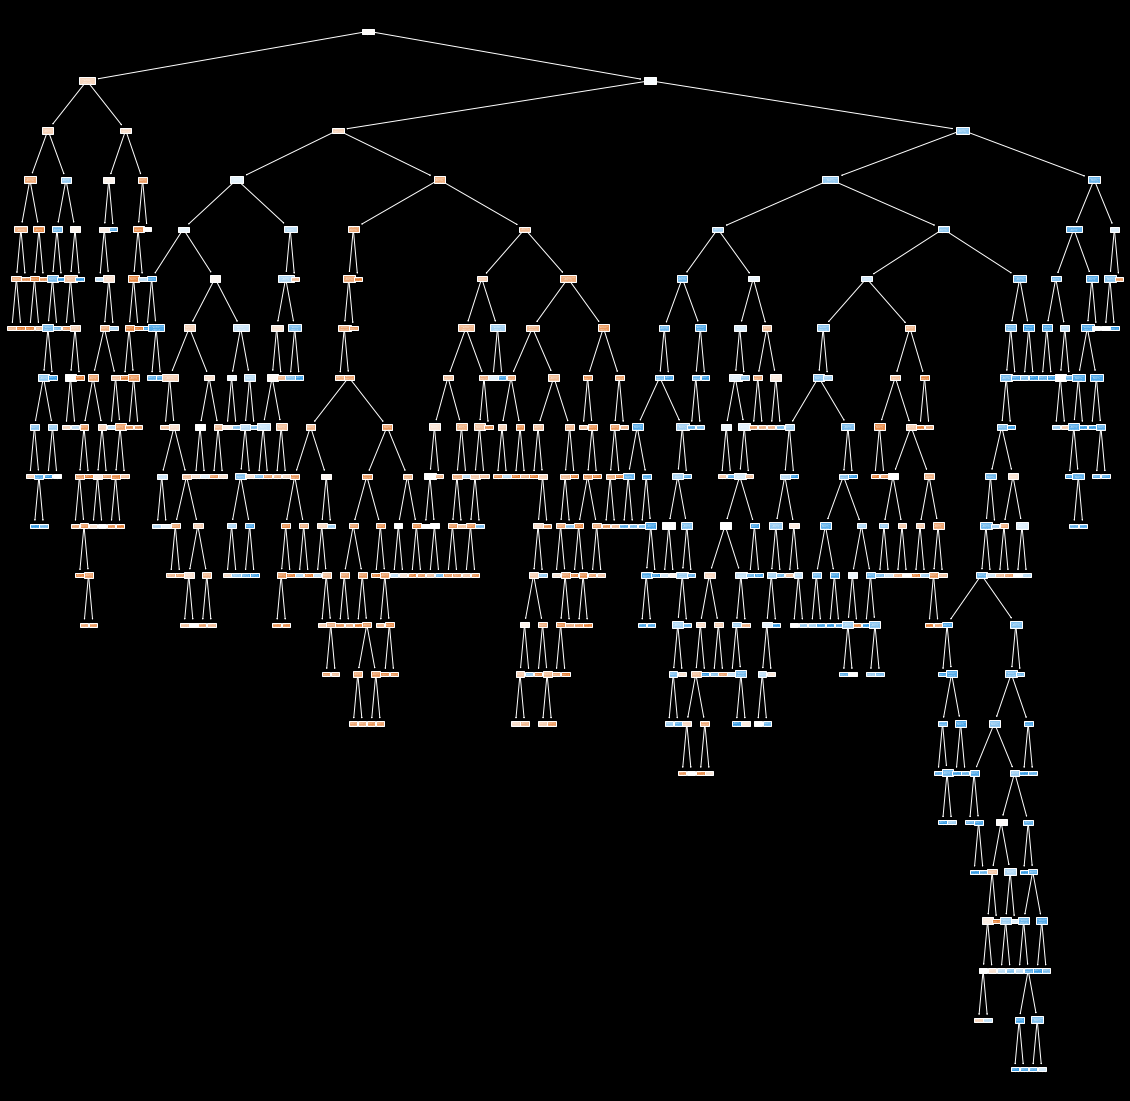

In [70]:
# Exercise 1.7 Visualize the tree

# use model.estimators_[n] as I used the random forest estimator

from sklearn import tree

plt.figure(figsize=(20,20))
_ = tree.plot_tree(best_rf.estimators_[150], feature_names=X_train.columns, filled=True)

**Exercise 1.7** What do you observe?
<br> We plotted several trees that had a maximum of decisions between 19 and 23. The arrangement of the branches varies significantly as e.g. the tree has sometimes only one long branch and sometimes several. In general, the tree size is too large to properly interpret the tree. One idea would be to analyze the importance of the features earlier in the analysis and to drop less important features. As a result, the trees need to make less decisions and get clearer. When they are easier to be interpreted, it is easy to find out the important decisions as they are closer to the root. The plot can be modified and information like the decision criteria or Gini Index can be added.

**Exercise 1 Wrap up** Before going on. Assign the predictions on the test set of your best model to the `y_hat` variable, and their related probabilities to the `y_prob` variable. Remember to use: `y_prob = model.predict_proba(X_test)`

In [10]:
# Exercise 1 Wrap up
y_hat = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)

**Exercise 1 Wrap up** Set a specific `random_state` in your model too. Otherwise if we rerun your results we might not be able to reproduce them!

**Note Philipp -> check if random_state 42 is everywhere + clear RAM in every cell**

## Part 2: Fairness and bias in Machine Learning

We already know the model you've built is biased. In the next exercises we are going to apply a debiasing method. Please, refer to Week 7, Part 3 for more hints on how to solve these exercises. But first a couple of questions about bias.

**Exercise 2.1** A few questions about bias.

**a) What are the most common types of data bias?**

**Note Philipp** -> all quotes from first video in Week 7
<br> 
<br> 1. Response and Activity Bias
<br> 2. Selection bias due to feedback loops
<br> 3. Bias due to system drift
<br> 4. Omitted variable bias
<br> 5. Societal Bias

**b) What are the potential bias sources/types in our case-study (i.e. recidivism)?**

**Note Philipp** -> all quotes from first video in Week 7
<br> 
<br> "1. Response and Activity Bias -> occurs in contend by humans (e.g. reviews on Amazon, tweets, posts on e.g. Facebook, Wikipedia entries...) -> bias: most data comes from a few sources, limited population, majority of users represent only a few demographic groups and geographic areas (e.g. 50% of Amazon reviews by 4% of the users) (We see this happening in our case because reoccuring offenders are responsible for most of the crimes therefor due to this bias they will get more negative predictions).
<br> 2. Selection bias due to feedback loops -> occurs when a model itself influences the generation of data that is used to train it -> Bias: ML models direct user attention to a small subset of items, ML models record user actions on these items, this bias occurs due to the non-random subset of the items presented to users
<br> 3. Bias due to system drift -> occurs when the system generating the data goes through changes over time -> Bias: concept drift: the definition of the target changes (e.g. change in the definition of fraud?), model drift: the way users interact changes (e.g. introduction of recommended searches in google -> more searches on similar topic)
<br> 4. Omitted variable bias -> occurs in data in which critical attributes that influence the outcome are missing -> Bias: Data generated by humans not recording certain info due to lack of access/ privacy, omitted variable is correlated with target, omitted variable is also corrlated with one or more predictor variables
<br> 5. Societal Bias -> occurs in content produced by humans, whether it be social media content or curated news articles -> Bias: data inherently contains bias and stereotypes, models trained on data discriminate on race, gender, or other categories." (There are reports that in the US minorities will be checked by police more often, so this bias is possible.)

**Exercise 2.2:** Equal Odds. We are going to use `y_prob` to debias the ML model for African-Americans and Caucasians.

In [11]:
# Preprocessing for Part 2:

# a) split the data set in train and test set (70/30 split) -> balanced data set grab equal amount of each target value
# train_test_split by sklearn

X_Caucasians = recidivism[recidivism.race_Caucasian == 1]
X_Caucasians = X_Caucasians.drop(columns = ['two_year_recid'])
#0 = defendant did not recommit a crime within two years; 1 = the defendant recommitted a crime within two years
y_Caucasians = recidivism[recidivism.race_Caucasian == 1]
y_Caucasians = y_Caucasians['two_year_recid']

rus = RandomUnderSampler(random_state=42, sampling_strategy=1)
X_res, y_res = rus.fit_resample(X_Caucasians, y_Caucasians)

X_Caucasians_train, X_Caucasians_test, y_Caucasians_train, y_Caucasians_test = train_test_split(X_res, y_res, test_size=0.3, \
    stratify=y_res, random_state=42) 

# to check if equal amount of each target value 
print(np.unique(y_Caucasians_train, return_counts=True))
print(np.unique(y_Caucasians_test, return_counts=True))

y_Caucasians_pred_random = best_rf.predict(X_Caucasians_test)

# Note Philipp: one model should be enough -> calculating the confusion matrices makes sense in the end to compare it with the results
#                                             of the different tasks

# y_Caucasians_pred_grid = best_grid.predict(X_Caucasians_test)

# print('Caucasians best grid: ')
# print(pd.crosstab(y_Caucasians_test, y_Caucasians_pred_grid, rownames=['Actual'], colnames=['Predicted']))

# print('Caucasians random: ')
# print(pd.crosstab(y_Caucasians_test, y_Caucasians_pred_random, rownames=['Actual'], colnames=['Predicted']))


#######

# Take targets and predictions only for *African-Americans*.

X_African_American = recidivism.loc[recidivism['race_African-American'] == 1]
X_African_American = X_African_American.drop(columns = ['two_year_recid'])
#0 = defendant did not recommit a crime within two years; 1 = the defendant recommitted a crime within two years
y_African_American = recidivism.loc[recidivism['race_African-American'] == 1]
y_African_American = y_African_American['two_year_recid']

rus = RandomUnderSampler(random_state=42, sampling_strategy=1)
X_res, y_res = rus.fit_resample(X_African_American, y_African_American)

X_African_American_train, X_African_American_test, y_African_American_train, y_African_American_test = \
    train_test_split(X_res, y_res, test_size=0.3, stratify=y_res, random_state=42) 

# to check if equal amount of each target value
print(np.unique(y_African_American_train, return_counts=True))
print(np.unique(y_African_American_test, return_counts=True))

y_African_American_pred_random = best_rf.predict(X_African_American_test)

# Note Philipp: one model should be enough -> calculating the confusion matrices makes sense in the end to compare it with the results
#                                             of the different tasks

# y_African_American_pred_grid = best_grid.predict(X_African_American_test)

# print('African_American best grid: ')
# print(pd.crosstab(y_African_American_test, y_African_American_pred_grid, rownames=['Actual'], colnames=['Predicted']))

# print('African_American random: ')
# print(pd.crosstab(y_African_American_test, y_African_American_pred_random, rownames=['Actual'], colnames=['Predicted']))

# b) Probabilities
y_Causiansians_prob = best_rf.predict_proba(X_Caucasians_test)[:,1] # probability for predicting one
y_African_American_prob = best_rf.predict_proba(X_African_American_test)[:,1]
# best_grid.classes_ -> to check order of the labels

(array([0, 1], dtype=int64), array([574, 575], dtype=int64))
(array([0, 1], dtype=int64), array([247, 246], dtype=int64))
(array([0, 1], dtype=int64), array([1059, 1060], dtype=int64))
(array([0, 1], dtype=int64), array([455, 454], dtype=int64))


We wanted to see Societal Bias by calculating the mean value of the predictions of reoffending, and we can see that it is present here. 

In [14]:
np.mean(y_African_American_prob)

0.5664206521000907

In [15]:
np.mean(y_Causiansians_prob)

0.4411673977687309


**Exercise 2.2.1:** Define the thresholds as `ths = np.linspace(1e-5,1-1e-5, 10)` and create a function that given a threshold `th` and `y_prob` returns `y_hat` as:

$$\begin{cases}\hat{y}=1, \mbox{ if } y_{prob} > th \\ \hat{y}=0, \mbox{ otherwhise}\end{cases}    \mbox(1)$$ 

In [16]:
# Exercise 2.2.1 (Note Philipp -> I decided to write a function that creates an array with all the y_hats as columns + 
#                                 maybe you need to adjust the model name in line 8 and 9 from rf_random to what i called the model in
#                                 end of task 1 -> choose the best one (hopefully i don't forget to highlight it))

# define thresholds
ths = np.linspace(1e-5,1-1e-5, 10)

# calculate y_pred for all thresholds based on:

# y_pred = 1 if y_prob > ths
# y_pred = 0, otherwise

# function creates an array with the y_hats for the different thresholds as columns

def auc_roc_graph_array(thresholds, y_prob):

    result_array = np.zeros((len(y_prob),len(thresholds)))

    for counter, threshold in enumerate(thresholds):
        
        y_pred_threshold = np.zeros(len(y_prob))

        for i, _ in enumerate(y_prob):
         
            if y_prob[i] > threshold:
                y_pred_threshold[i] = 1
            else:
                y_pred_threshold[i] = 0
    
        result_array[:, counter] = np.copy(y_pred_threshold)

    return(result_array)

**Exercise 2.2.2:** To find the two thresholds that correct for the bias for African-Americans and Caucasians, you can either compute the distance of the ROC curve points or visually find the thresholds (as described in Week 7 Ex. 3.3). Describe the method you have used to find the thresholds (i.e. Visual or Computational) and how you used it to identify the thresholds. What thresholds did you find?

In [17]:
# Exercise 2.2.2
 
# Preparation: function to compute TPR and FPR (input y_test, y_pred)

def TPR_FPR(auc_roc_graph_array, y_test):

    y_test = y_test.values

    TPR = np.zeros(auc_roc_graph_array.shape[1])
    FPR = np.zeros(auc_roc_graph_array.shape[1])

    for threshold in range(auc_roc_graph_array.shape[1]):

        TP = 0
        FP = 0
        TN = 0
        FN = 0

        for y_pred_index in range(auc_roc_graph_array.shape[0]):
 
            if y_test[y_pred_index]==auc_roc_graph_array[y_pred_index, threshold]==1:
                TP += 1
            if auc_roc_graph_array[y_pred_index, threshold]==1 and y_test[y_pred_index]!=auc_roc_graph_array[y_pred_index, threshold]:
                FP += 1
            if y_test[y_pred_index]==auc_roc_graph_array[y_pred_index, threshold]==0:
                TN += 1
            if auc_roc_graph_array[y_pred_index, threshold]==0 and y_test[y_pred_index]!=auc_roc_graph_array[y_pred_index, threshold]:
                FN += 1
        
        TPR[threshold] = TP/(TP + FN)
        FPR[threshold] = FP/(FP + TN)

    return(TPR, FPR)

#This function takes as an input y, y_probs, thr 
#and returns the points to plot the ROC curve and their threshold
def roc_curve(y_test, y_prob, ths):
  #initialize roc as an empty np.array
  roc = np.array([])
  #loop over thresholds
  #convert y_prob in y_hat
  y_hat = auc_roc_graph_array(ths, y_prob)
  #compute TPR and FPR
  TPR, FPR = TPR_FPR(y_hat, y_test)
  for counter, th in enumerate(ths):
    #add threshold and point to roc array
    roc = np.append(roc, [th, FPR[counter], TPR[counter]])
  #return roc
  return roc.reshape(-1, 3)

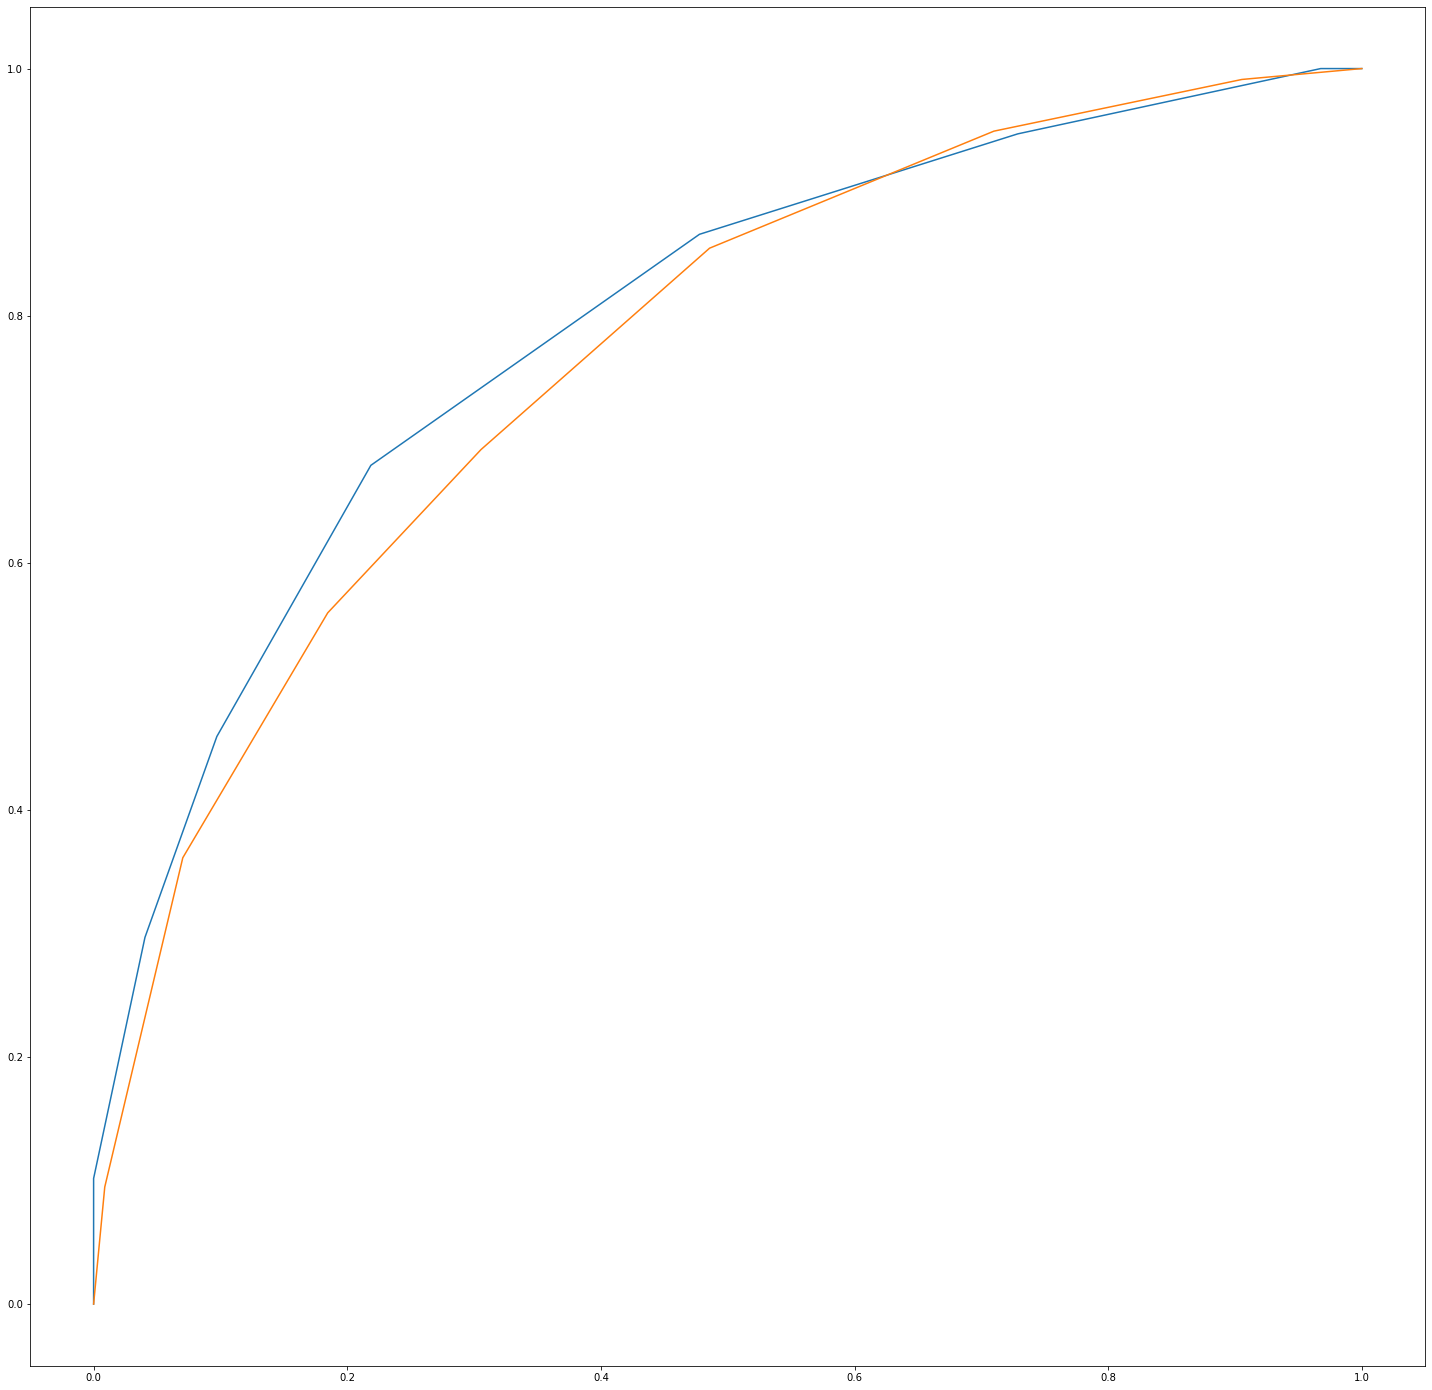

In [18]:
# Exercise 2.2.2
# Find Thresholds that lead to the closest points for the two groups on the ROC curve

# Exercise 2.2.2 a) regular plot

# calculate values and plot

Caucasians_roc_curve_values = roc_curve(y_test = y_Caucasians_test, y_prob = y_Causiansians_prob, ths = ths)
African_American_roc_curve_values = roc_curve(y_test = y_African_American_test, y_prob = y_African_American_prob, ths = ths)

plt.figure(figsize=(25,25))
plt.plot(Caucasians_roc_curve_values[:,1], Caucasians_roc_curve_values[:,2])
plt.plot(African_American_roc_curve_values[:,1], African_American_roc_curve_values[:,2])

In [19]:
# Exercise 2.2.2 b) graphically with Bokeh

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Legend, HoverTool, Title
from bokeh.io import output_notebook, show
from bokeh.models.tools import WheelZoomTool 

# roc_curves
roc_ca = roc_curve(y_test = y_Caucasians_test, y_prob = y_Causiansians_prob, ths = ths)
roc_aa = roc_curve(y_test = y_African_American_test, y_prob = y_African_American_prob, ths = ths)

roc_curves = pd.DataFrame({'FPR_AA':roc_aa[:,1], 'TPR_AA':roc_aa[:,2], 'FPR_CA':roc_ca[:,1], 'TPR_CA':roc_ca[:,2]})

roc_curves = ColumnDataSource(roc_curves)

# 
# DataFrame with columns x, y, th where x is the combined list of FPR_AA and FPR_CA, 
# y is the combined list of TPR_AA and TPR_CA, and th 

thresholds = pd.DataFrame({'x':np.concatenate((roc_aa[:,1], roc_ca[:,1])), 'y':np.concatenate((roc_aa[:,2], roc_ca[:,2])),\
    'th':np.concatenate((roc_aa[:,0], roc_ca[:,0]))})
thresholds = ColumnDataSource(thresholds)

# plotting
p = figure(tools='hover', title = 'ROC Curves')
p.line('FPR_AA', 'TPR_AA', source = roc_curves, legend_label = 'African-American')
p.line('FPR_CA', 'TPR_CA', source = roc_curves, color = 'green', legend_label = 'Caucasians')
p.circle('x','y',source=thresholds, fill_color = 'red', hover_fill_color = 'pink') 

hover = p.select(dict(type=HoverTool))
hover.tooltips = [
    ("FPR", "@x"),
    ("TPR", '@y'),
    ('Threshold', '@th')
    ]

p.add_layout(Title(text="FPR", align="center"), "below")
p.add_layout(Title(text="TPR", align="center"), "left")

p.legend.location = "top_left"
p.legend.click_policy="hide"

p.add_tools(WheelZoomTool())


show(p)
output_notebook()

Loading BokehJS ...

In [20]:
# Exercise 2.2.2 c) computational solution 

#This function takes as an input the points from one roc (first group) and the other (second group) and order the points by their distance in ascending order 
  
def closest_points(points1, points2):
  #initialize result
  res = list()
  #loop over points in group 1
  for pi in points1:
    #loop over points in group 2
    for pj in points2:
      #add points and their distance to res
      res.append(((pi, pj), np.linalg.norm(pi[1:] - pj[1:])))
  #return sorted result
  return sorted(res, key = lambda x: x[1])

closest_points_roc_curve = closest_points(Caucasians_roc_curve_values[:,[1,2]], African_American_roc_curve_values[:,[1,2]])

closest_points_roc_curve

[((array([1., 1.]), array([1., 1.])), 0.0),
 ((array([1., 1.]), array([1., 1.])), 0.0),
 ((array([0.96761134, 1.        ]), array([1., 1.])), 0.0),
 ((array([0.96761134, 1.        ]), array([1., 1.])), 0.0),
 ((array([0., 0.]), array([0., 0.])), 0.0),
 ((array([0., 0.]), array([0., 0.])), 0.0),
 ((array([0.72874494, 0.94715447]), array([0.70989011, 0.94933921])),
  0.002184735503742763),
 ((array([0.        , 0.10162602]), array([0.00879121, 0.09471366])),
  0.006912359872497401),
 ((array([1., 1.]), array([0.90549451, 0.99118943])), 0.008810572687224627),
 ((array([0.96761134, 1.        ]), array([0.90549451, 0.99118943])),
  0.008810572687224627),
 ((array([0.47773279, 0.86585366]), array([0.48571429, 0.85462555])),
  0.011228107875792426),
 ((array([0.21862348, 0.67886179]), array([0.30549451, 0.69162996])),
  0.012768167329250457),
 ((array([0.72874494, 0.94715447]), array([0.90549451, 0.99118943])),
  0.044034955768059936),
 ((array([1., 1.]), array([0.70989011, 0.94933921])), 0.0

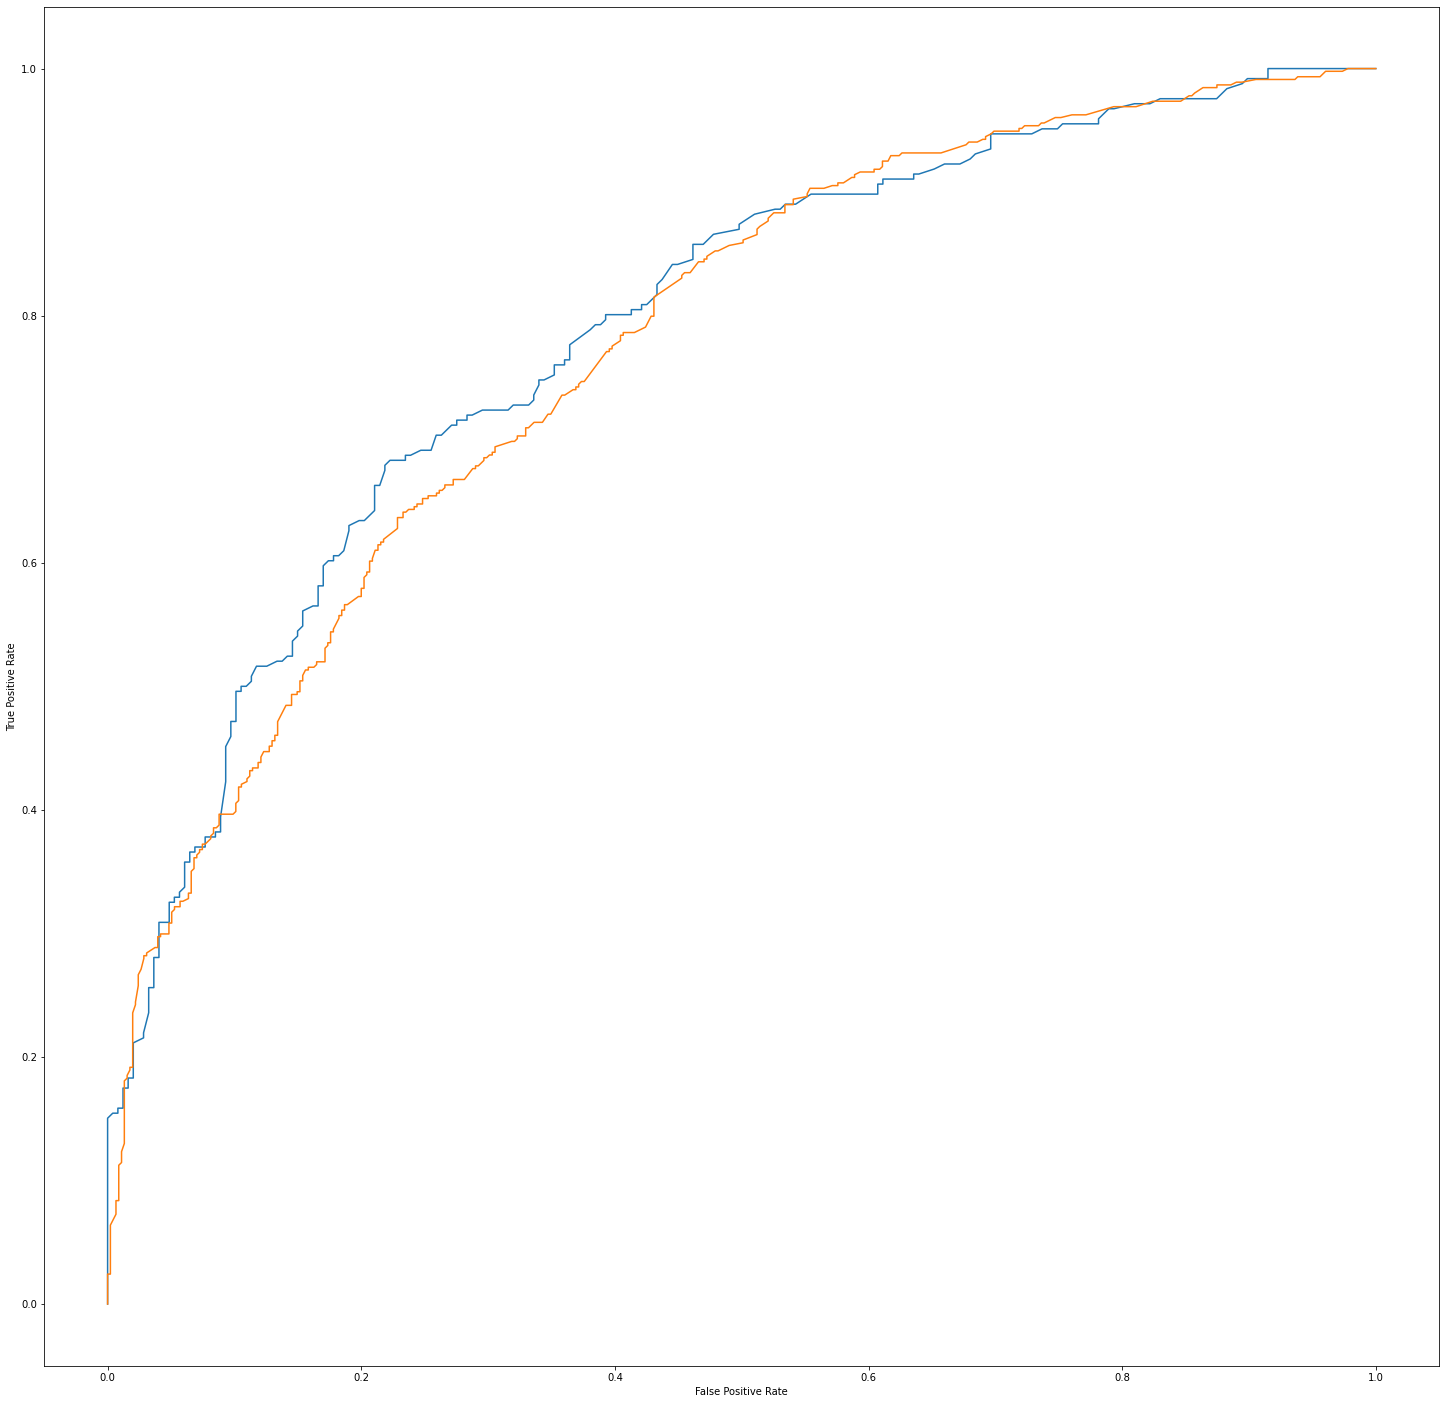

In [21]:
# Exercise 2.2.2 addition -> simpler way, but not asked in task -> to check results

fpr, tpr, _ = metrics.roc_curve(y_Caucasians_test, y_Causiansians_prob)
fpr_2, tpr_2, _ = metrics.roc_curve(y_African_American_test, y_African_American_prob)

#create ROC curve
plt.figure(figsize=(25,25))
plt.plot(fpr,tpr)
plt.plot(fpr_2,tpr_2)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Exercise 2.2.2**
<br> **a) Describe the method you have used to find the thresholds (i.e. Visual or Computational).**

<br>We have used the visual metod, plotted the ROC curve, and then we looked for the point where the ROC curve of African American and ROC curve of Caucasians intersect. Note: this curves intersected in multiple places, so we have chosen the one that has the best true positive rate compared to false positive rate.

<br> **b) How you used this method to identify the thresholds?** 

<br> We aimed for balanced TPR and FPR, because if we used threshold values close to 0 and 1, we would get a very inaccurate classifier.
<br> So we found a balance between a good classifier (balanced TPR and FPR) and minimize distance between points of the different thresholds (maximize fairness of the algorithm) (essentialy check where the ROC curves intersect on the plot) -> weigh up different options (second lecture video of Week 7: 27:45 min)

<br> **c) What thresholds did you find?**

<br> Threshold African-American: 0.4444 -> rather high TPR: 0.848
<br> Threshold Caucasians: 0.3333 -> rather high TPR: 0.87
<br> Balance as distance is rather small, but TPRs are high -> alternatively high FPR possible, but larger distance -> the largest distance if really balanced TPRs

<br> In many applications(e.g. hiring), people care more about the true positive rate than true negative rate so many works focus on the following relaxed version: https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb


**Exercise 2.2.3:** Debias the model output by re-computing $\hat{y}$ with the thresholds you found. 
<br>   **Hint 1** This means that you have to take `y_prob` of your model African-Americans and apply Eq. (1) with the threshold for African-Americans, and then repeat with the different threshold for Caucasians.
<br>   **Hint 2** You shouldn't rerun your model!

In [22]:
# Exercise 2.2.3
Caucasians_auc_roc_graph_array = auc_roc_graph_array(ths, y_Causiansians_prob)
African_American_auc_roc_graph_array = auc_roc_graph_array(ths, y_African_American_prob)

th_African_American = ths[4]
th_Caucasians = ths[3]

y_hat_Afrian_American = African_American_auc_roc_graph_array[:,4]
y_hat_Caucasians = Caucasians_auc_roc_graph_array[:,3]

**Exercise 2.2.4:** Now plot the confusion matrices for African-Americans and Caucasian after you debiased the method. What do you observe? What do you think the problem with this debiasing method is (Refer to Week 7 for more hints)?

In [29]:
# Exercise 2.2.4
# NOT PLOTTED -> EXERCISE WANTS A PLOT can be done with an heatmap by sns e.g.
# https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
matrix = pd.crosstab(y_Caucasians_test, y_hat_Caucasians, rownames=['Actual'], colnames=['Predicted'])
print('Equal Odds Caucasians: ')
print(matrix)
matrix2 = pd.crosstab(y_African_American_test, y_hat_Afrian_American, rownames=['Actual'], colnames=['Predicted'])
print('Equal OddsAfrican American: ')
print(matrix2)

Equal Odds Caucasians: 
Predicted  0.0  1.0
Actual             
0          129  118
1           33  213
Equal OddsAfrican American: 
Predicted  0.0  1.0
Actual             
0          234  221
1           66  388


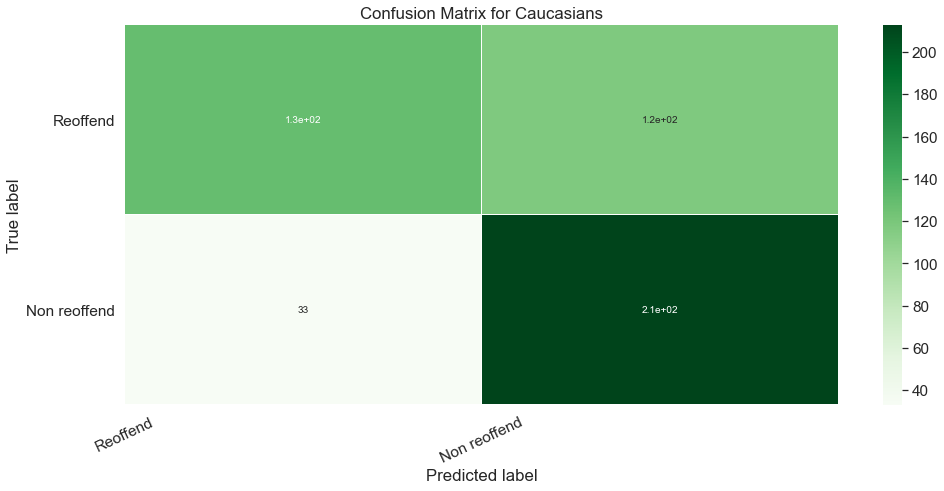

In [32]:
import seaborn as sns
# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Reoffend','Non reoffend']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Caucasians')
plt.show()

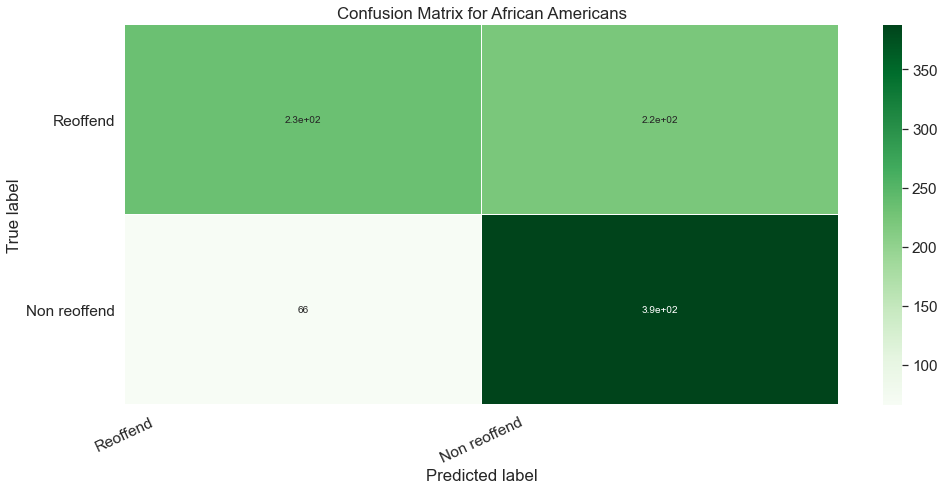

In [33]:
# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix2, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Reoffend','Non reoffend']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for African Americans')
plt.show()

**Exercise 2.2.4:**
<br> **a) What do you observe?**
<br> a lot of false positive values + a lot of true negative values -> does this make sense in regards of the previous concern of high TPRs in regards to the chosen thresholds? in regards to the roc graph? 
<br> **b) What do you think the problem with this debiasing method is (Refer to Week 7 for more hints)?**
<br> some groups have special rights on order to protect minorities, but if we drop the feature (or feature combination) containing this information, we loose a logical connection between the decision and the person -> it also makes it harder to compare ethnical groups, if they have different rights as we try to make them equal by applying these methods



<br> "Flaws:
It may not help closing the gap between two groups. For example, imagine group A has 100 applicants and 58 of them are qualified while group B also have 100 applicants but only 2 of them are qualified. If the company decides to accept 30 applicants and satisfies equality of opportunities, 29 offers will be conferred to group A while only 1 offer will be conferred to group B. If the job is a well-paid job, group A tends to have a better living condition and affords better education for their kids, and thus enable them to be qualified for such well-paid jobs when they grow up. The gap between group A and group B will tend to be enlarged over time."https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb

## Part 3: Communicate your story and results to others

> *Exercise 3* Fill the article below with the title, subtitles, sections, visualizations and references!
> 
>    * **Note 1** Please, have a look at Week 8 for instructions on how to complete the article and make the visualizations.
>    * **Note 2** Make sure **you add the code** that generate your visualizations! This is really important.
>    * **Note 3** You should have all the necessary inputs to make the visualizations from the exercises in Part 1 and Part 2.

# ADD YOUR TITLE HERE

**Introduction.** Write your introduction here. Think about the audience. This is an article for the general public, so you should try to make it engaging, relatable, not too technical etc.

In [23]:
#First viz here: (Week 8 Visualization 1) Interactive visualization with Bokeh

Visualization 1. Exploratory data analysis. The interactive visualization we are going to make uses the same code you put together for Week 7 Exercise 1.1 (where we made bar plot of the number of recommited crimes across ages divided by race), with a few changes/adds on:

First, instead of age, create an age_group column to use on the x-axis. The groups should be .
Second, instead of using the number of recommitted crimes for each race, compute the total number of samples per age group and the total number of recommitted crimes per age group.
Third, we are going to add a HoverTool as in Week 7, Exercise 1.2 showing two fractions:
the number of recommitted crimes of the age group over the number of samples of the age group;
the number of recommitted crimes of the age group over the total recommitted crimes across age groups.
The result should look similar to this.
Now that you have the code for this plot, create other two plots in the same way but by using sex and race.
Finally, combine the three plots into one unique visualization with Tabs and Panel. To have an hint on how to do it, have a look at this solution
You just created your first visualization for the article! You can personalize it as you like, but it should look somewhat like the one in the following video:

In [90]:
age_groups = [0,21,41,61,81,100]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']
recidivism['age_group'] = pd.cut(recidivism['age'], bins=age_groups, labels=labels, right=False)
recidivism = recidivism.drop(columns=['age'])

In [93]:
recidivism_age = recidivism.groupby(by=['age_group']).sum()
recidivism_age

,sex,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other
age_group,,,,,,,,,,,,
0-20,154.0,34,46,72,151,141,112.0,1.0,46.0,12.0,1.0,17.0
21-40,3479.0,289,506,586,13602,2105,2419.0,18.0,1260.0,358.0,7.0,234.0
41-60,1212.0,41,8,19,5659,516,585.0,10.0,690.0,125.0,3.0,83.0
61-80,142.0,0,0,0,565,40,56.0,2.0,99.0,11.0,0.0,8.0
81-100,2.0,0,0,0,2,1,0.0,0.0,0.0,2.0,0.0,0.0


In [92]:
#HoverTool
# the number of recommitted crimes of the age group over the number of samples of the age group
#the number of recommitted crimes of the age group over the total recommitted crimes across age groups

In [98]:
#create other two plots in the same way but by using sex and race

In [94]:
recidivism_sex = recidivism.groupby(by=['sex']).sum()
recidivism_sex

,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other
sex,,,,,,,,,,,
0,13,46,63,2436,412,549.0,2.0,477.0,82.0,2.0,58.0
1,351,514,614,17543,2391,2623.0,29.0,1618.0,426.0,9.0,284.0


In [97]:
#I think we don't need to drop column 'race' in the first task but just give our dataset 
#a different name when we make dummies so we can keep the race for this task
recidivism_race = recidivism.groupby(by=['race']).sum()
recidivism_race

KeyError: 'race'

In [99]:
#Finally, combine the three plots into one unique visualization with Tabs and Panel

**Results from exploratory data analysis.** Write this section here. The aim is to show that the data is biased, which might have an impact on the model. Relate this part to the first visualization.

In [24]:
#Second viz here: (Week 8 Visualization 2) plot with 3 subplots (Feature importances, Confusion Matrix, Percentage difference)

In [ ]:
#We used a Random Forest, so we can also have the standard deviation for each feature importance by following these:
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html. 
#Plot the feature importances and standard deviations by using plt.errorbar().

In [ ]:
#The second subplot shows the confusion matrix for the entire model (as in Week 7 Ex. 2).
#We need to use the confusion_matrix() function from sklearn.metrics and make sure to add the parameter 
#normalize="true" which normalizes the rows of the confusion matrix and will help the comparison in the third subplot.
#Hint on how to plot it: https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

In [ ]:
#The third subplot shows the difference between the values of the confusion matrices of the two populations 
#we are interested in, i.e. African-Americans and Caucasian, and the confusion matrix of our model:
#Daa = CMaa - CMtot
#Dca = CMca - CNtot
# CMaa, CMca and CMtot are the confusion matrices for African-Americans, Caucasians, and the total one from the model respectively.
#We do not have to retrain the model to get CMaa and CMca.
#Display the values for the difference in TP, TN, FP, and FN in an horizontal bar plot, where you have the 
#difference on the x-axis, and the TP, TN, FP and FN labels on the y-axis. 
#You can transform the difference in percentage if you wish.
#Finally, customize the plot as you like: choose colors, add labels, titles, legends, captions etc.
#i.e. https://raw.githubusercontent.com/suneman/socialdata2022/main/files/W8_Viz2_lollipop.png
#https://raw.githubusercontent.com/suneman/socialdata2022/main/files/W8_Viz2_custom.png

**Results from the classification task.** Write this section here. The aim is to show that the model is biased as it is learning from biased data. Relate this part to the second visualization.

In [25]:
#Third viz here: (Week 8 Visualization 3) plot with 2 subplots (ROC curve and selected threshold, TPR and FPR before and after debiasing)

In [ ]:
#The first subplot shows the AUC-ROC curve and highlights the threshold found for the model. 
#It is the same visualization of Week 7, Ex. 3.3 but by using matplotlib, seaborn, etc. instead of Bokeh. 
#I want you to chose the points on the curve, so make sure to add them:
#Mark the points you chose on the curves, you can for instance highlight them with a different color or symbol, 
#or you can use a circle or point at them with arrows... it's up to you.
#Add a text on the figure that display the thresholds chosen. You can add texts on matplotlib figures plt.figtext().

In [ ]:
#The second subplot shows the True-Positive and False-Positive rates for African-Americans and Caucasian before 
#and after the debiasing method. We will use a slope chart.
#The slope chart will have 4 lines: TPR for African-Americans, TPR for Caucasian, FPR for African-Americans, 
#and FPR for Caucasian. Each line has two points, i.e. the value of the rate before and after debiasing. 
#https://raw.githubusercontent.com/suneman/socialdata2022/main/files/W8_Viz3_custom.png. 
#Again, customize it as you like, make it yours! make it better!
#https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/#18.-Slope-Chart

In [ ]:
#Now that we have the visualizations, we can move them in the structure of the article and write the article. 
#We should include our code, but if we want to hide the input cells to make your notebook look like an article 
#we can do it by installing an nbextension!

**Results from debiasing method.** Write this section here. The aim is to show that there are methods that can help to enhance fairness in cases as this one. Relate this part to the third visualization.

**Limitations and conclusions.** Write this part here. These are your main take aways, the end of your story, where you should also highlight possible implications/limitations of what you presented.

**References.** Any article need good sources! Whenever you make a statement, refer to data sources, previous studies, methods, etc. add a reference. 

1. https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/
2. https://medium.com/analytics-vidhya/what-is-balance-and-imbalance-dataset-89e8d7f46bc5
3. https://www.kdnuggets.com/2020/04/data-transformation-standardization-normalization.html
4. https://www.analyticsvidhya.com/blog/2020/05/decision-tree-vs-random-forest-algorithm/
5. https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
6. https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
7. 

**Assignment Contributions**:

* id1: ST34 -> 100 % part 1 + __ % part 2
* id2
* id3